In [1]:
try:
    import google.colab
    IN_COLAB = True
    %pip uninstall scikit-learn -y
    %pip install scikit-learn
    %pip install jaxtyping
    %pip install umap-learn
    from tqdm.notebook import tqdm, trange

    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    %cd /content/gdrive/MyDrive/CCS/experiment1
except:
    IN_COLAB = False
    from tqdm import tqdm, trange

import os, sys, gc
sys.path.append("../utils/")

from CCS import *

import pickle
import numpy as np
import pandas as pd
import torch as t
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN
from cluster_norm.utils.utils import extract_last_word

from copy import deepcopy

# Experiment Setup

In [17]:
n_probes = 20
layer = 23
num_random_words = 2
model = "mistral-7b"
dataset = "imdb"
bias = True

# Specify paths and load prompts

In [18]:
activations_folder = f"/home/wombat_share/laurito/cluster_norm/src/cluster_norm/_experiment1/activations/{model}/{dataset}/{num_random_words}/{layer}"
output_folder = f"./output/{model}/{dataset}/{num_random_words}/layer_{layer}/{"bs" if bias else "non_bs"}"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

prompts = pd.read_json(f"./prompt_datasets/{dataset}/prompts_{num_random_words}.jsonl", orient="records", lines=True)
if dataset == "imdb":
    labels_sentiment = (prompts["sentiment"] == "positive").values
last_word = extract_last_word(prompts["template_pos_bs"].iloc[0])
labels_bs = prompts["template_pos_bs"].apply(lambda x: x.endswith(last_word)).values

# Load activations + shuffling

In [19]:
if bias:
    pos = t.load(f"{activations_folder}/pos_bs.pt")
    neg = t.load(f"{activations_folder}/neg_bs.pt")
else:
    pos = t.load(f"{activations_folder}/pos.pt")
    neg = t.load(f"{activations_folder}/neg.pt")

# shuffle pos, neg and labels_bs and labels_sentiment in the same way
perm = t.randperm(len(pos))
pos, neg = pos[perm], neg[perm]
labels_sentiment, labels_bs = labels_sentiment[perm], labels_bs[perm]

split = int(0.8*len(pos))
train_pos, test_pos = pos[:split], pos[split:]
train_neg, test_neg = neg[:split], neg[split:]
train_labels_sentiment, test_labels_sentiment = labels_sentiment[:split], labels_sentiment[split:]
train_labels_bs, test_labels_bs = labels_bs[:split], labels_bs[split:]


# Logistic Regression

In [20]:
# Logistic Regression
from cluster_norm.utils.train import fit_logreg

lr = fit_logreg(train_pos, train_neg, train_labels_sentiment)
t.save(lr, f"{output_folder}/lr.pt")
lr.score(test_pos-test_neg, test_labels_sentiment)

0.805

In [21]:
lr = fit_logreg(train_pos, train_neg, train_labels_bs)
t.save(lr, f"{output_folder}/lr.pt")
lr.score(test_pos-test_neg, test_labels_bs)

1.0

# CRC

### Burns norm

In [22]:
# # CRC 
from cluster_norm.utils.train import fit_crc

crc = fit_crc(deepcopy(train_pos), deepcopy(train_neg), "burns")
t.save(crc, f"{output_folder}/crc_burns.pt")
acc_crc = crc.evaluate(test_pos, test_neg, test_labels_sentiment)
acc_crc

CRC norm burns


0.52

### Cluster norm

In [23]:
crc = fit_crc(deepcopy(train_pos), deepcopy(train_neg), "cluster")
t.save(crc, f"{output_folder}/crc_cluster.pt")
acc_crc = crc.evaluate(test_pos, test_neg, test_labels_sentiment)
acc_crc

CRC norm cluster


0.525

In [24]:
evals = {}
for norm in ["burns", "cluster"]:
    crc = fit_crc(train_pos, train_neg, norm)
    evals[f"acc_crc_{norm}"] = crc.evaluate(test_pos, test_neg, test_labels_sentiment)
    
print(evals)


CRC norm burns
CRC norm cluster
{'acc_crc_burns': 0.52, 'acc_crc_cluster': 0.525}


# CCS

### Burns norm

In [25]:
from cluster_norm.utils.train import fit_ccs

_, ccs = fit_ccs(
    pos=train_pos,
    neg=train_neg,
    labels=train_labels_sentiment,
    normalize="burns",
    n_probes=n_probes,
    device=t.device("cuda")
)
t.save(ccs, "ccs_burns.pt")

CCS norm burns


fitting probes:   0%|          | 0/20 [00:00<?, ?it/s]/home/laurito/miniconda3/envs/cluster/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
fitting probes:  65%|██████▌   | 13/20 [05:51<03:10, 27.24s/it]

In [ ]:
# ccs = t.load("ccs.pt")

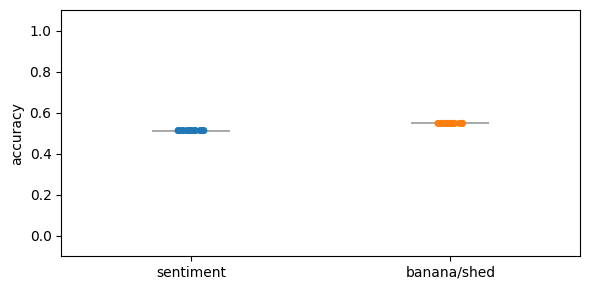

In [ ]:
sent_accs, bs_accs = [], []
for probe in ccs.probes:
    preds = ccs.predict(probe, test_pos, test_neg, True)
    sent_acc = (preds == test_labels_sentiment).mean()
    sent_acc = max(sent_acc, 1-sent_acc)
    bs_acc = (preds == test_labels_bs).mean()
    bs_acc = max(bs_acc, 1-bs_acc)
    sent_accs.append(sent_acc)
    bs_accs.append(bs_acc)

df = pd.DataFrame(columns=["setting", "accuracy"])
df["setting"] = ["sentiment"]*n_probes + ["banana/shed"]*n_probes
df["accuracy"] = sent_accs + bs_accs

fig, ax = plt.subplots(figsize=(6, 3))
sns.stripplot(x="setting", y="accuracy", data=df, jitter=0.05, ax=ax, hue="setting")
sns.violinplot(x="setting", y="accuracy", data=df, ax=ax, hue="setting",
               cut=0, inner=None, width=0.3, alpha=0.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel("")
ax.set_ylabel("accuracy")
plt.tight_layout()
plt.show()

In [ ]:
print("sent_accs mean:", np.mean(sent_accs))
print("sent_accs std:", np.std(sent_accs))

print("bs_accs mean:", np.mean(bs_accs))
print("bs_accs std:", np.std(bs_accs))

sent_accs mean: 0.5124999999999998
sent_accs std: 1.1102230246251565e-16
bs_accs mean: 0.5474999999999999
bs_accs std: 1.1102230246251565e-16


### Cluster Norm

In [ ]:
_, ccs_cluster = fit_ccs(
    pos=train_pos,
    neg=train_neg,
    labels=train_labels_sentiment,
    normalize="cluster",
    n_probes=n_probes,
    device=t.device("cuda")
)
t.save(ccs_cluster, "ccs_burns.pt")

CCS norm cluster


fitting probes: 100%|██████████| 20/20 [17:42<00:00, 53.12s/it]


In [ ]:
t.save(ccs_cluster, "ccs_cluster.pt")
# ccs_cluster = t.load("ccs_cluster.pt")

sentiment accuracy: 0.69
bias accuracy: 0.535
sentiment accuracy: 0.675
bias accuracy: 0.5349999999999999
sentiment accuracy: 0.7125
bias accuracy: 0.5475
sentiment accuracy: 0.6725
bias accuracy: 0.5325
sentiment accuracy: 0.785
bias accuracy: 0.54
sentiment accuracy: 0.8575
bias accuracy: 0.5325
sentiment accuracy: 0.795
bias accuracy: 0.505
sentiment accuracy: 0.7425
bias accuracy: 0.5725
sentiment accuracy: 0.73
bias accuracy: 0.54
sentiment accuracy: 0.68
bias accuracy: 0.53
sentiment accuracy: 0.6625
bias accuracy: 0.5225
sentiment accuracy: 0.7050000000000001
bias accuracy: 0.55
sentiment accuracy: 0.725
bias accuracy: 0.54
sentiment accuracy: 0.67
bias accuracy: 0.6799999999999999
sentiment accuracy: 0.7175
bias accuracy: 0.5575
sentiment accuracy: 0.735
bias accuracy: 0.5449999999999999
sentiment accuracy: 0.6775
bias accuracy: 0.6475
sentiment accuracy: 0.6925
bias accuracy: 0.5475
sentiment accuracy: 0.6075
bias accuracy: 0.6225
sentiment accuracy: 0.725
bias accuracy: 0.53


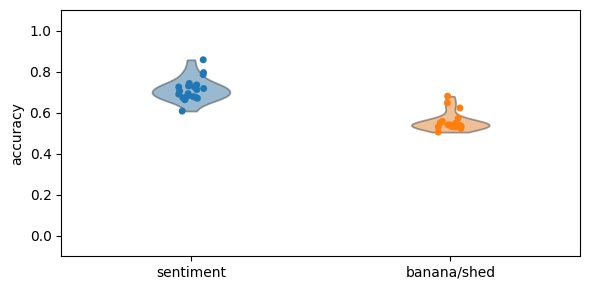

In [ ]:
sent_accs, bs_accs = [], []
for probe in ccs_cluster.probes:
    preds = ccs_cluster.predict(probe, test_pos, test_neg, True)
    sent_acc = (preds == test_labels_sentiment).mean()
    sent_acc = max(sent_acc, 1-sent_acc)
    bs_acc = (preds == test_labels_bs).mean()
    bs_acc = max(bs_acc, 1-bs_acc)
    sent_accs.append(sent_acc)
    bs_accs.append(bs_acc)
    print("sentiment accuracy:", sent_acc)
    print("bias accuracy:", bs_acc)

df = pd.DataFrame(columns=["setting", "accuracy"])
df["setting"] = ["sentiment"]*n_probes + ["banana/shed"]*n_probes
df["accuracy"] = sent_accs + bs_accs

fig, ax = plt.subplots(figsize=(6, 3))
sns.stripplot(x="setting", y="accuracy", data=df, jitter=0.05, ax=ax, hue="setting")
sns.violinplot(x="setting", y="accuracy", data=df, ax=ax, hue="setting",
               cut=0, inner=None, width=0.3, alpha=0.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel("")
ax.set_ylabel("accuracy")
plt.tight_layout()
plt.show()

In [ ]:
print("sent_accs mean:", np.mean(sent_accs))
print("sent_accs std:", np.std(sent_accs))

print("bs_accs mean:", np.mean(bs_accs))
print("bs_accs std:", np.std(bs_accs))

sent_accs mean: 0.712875
sent_accs std: 0.05325220065875213
bs_accs mean: 0.555625
bs_accs std: 0.0427629731777387
